In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 25.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import nltk
import collections
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, losses, Model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from scipy import spatial

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[:2000,:]

In [ ]:
df['sentiment'][df.sentiment == 'positive'] = 1

In [ ]:
df.tail()

,review,sentiment
1995,"Feeling Minnesota, directed by Steven Baigelma...",negative
1996,THE CELL (2000) Rating: 8/10<br /><br />The Ce...,1
1997,"This movie, despite its list of B, C, and D li...",negative
1998,I loved this movie! It was all I could do not ...,1
1999,This was the worst movie I have ever seen Bill...,negative


In [ ]:
df['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
df['sentiment'][2]

'positive'

# Bag-of-Words - preparation

In [ ]:
# list of stopwords for removal

In [ ]:
STOPWORDS = ['br', 'b', 'le', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
             'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
             'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
             'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
             'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thats', 'would',
             "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
             'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 
             'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
             'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
             'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
             'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
             'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
             'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
             'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# word lemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def calculateBOW(wordset,l_doc):
    tf_diz = dict.fromkeys(wordset,0)
    for word in l_doc:
        tf_diz[word]=np.count_nonzero(l_doc == word)
    return tf_diz

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
X = np.asarray(df.iloc[:,0])
data = [np.array([lemmatizer.lemmatize(x) for x in np.setdiff1d(re.sub(r"[^a-zA-Z0-9]", " ", obs.lower()).split(), STOPWORDS)]) for obs in X]
vocabulary = np.unique(np.concatenate(data))
data_bow = pd.DataFrame([calculateBOW(vocabulary,obs) for obs in data])
has_digit = [bool(re.search(r'\d', v)) for v in vocabulary]
data_bow = data_bow.drop(columns=vocabulary[has_digit])

In [ ]:
# removing least frequent words

In [ ]:
colmeans = pd.DataFrame(data_bow.mean(axis=0)).reset_index()
data_bow1 = data_bow[data_bow.columns[(colmeans[0]>0.01) & (colmeans[0]<0.5)]]

# Bag of Words - contrastive

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_bow, y_cat, test_size=0.5, random_state=42)
X_train = np.array(X_train.reset_index(drop=True))
X_test = np.array(X_test.reset_index(drop=True))
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)

In [ ]:
X_train_tensor.shape

TensorShape([1000, 318])

In [ ]:
def encoder_fn(input_shape):
    input = layers.Input((len_bag,))
    x = tf.keras.layers.BatchNormalization()(input)
    x = layers.Dense(512)(x)
    x = layers.Dense(128)(x)
    outputlayer = layers.Dense(128, activation='relu')(x)

    embedding_network = tf.keras.Model(input, outputlayer)
 
    model = Model(inputs=input, outputs=outputlayer)
    return model

def add_projection_head(input_shape, encoder):
    inputs = layers.Input(shape=input_shape, name='inputs')
    features = encoder(inputs)
    outputs = layers.Dense(64, activation='relu', 
                      name='projection_head', 
                      dtype='float32')(features)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def classifier_fn(input_shape, encoder, trainable=False):
    for layer in encoder.layers:
        layer.trainable = trainable
        
    inputs = layers.Input(shape=input_shape, name='inputs')
    
    features = encoder(inputs)
    outputs = layers.Dense(2, activation='softmax', 
                      name='outputs', dtype='float32')(features)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
class SupervisedContrastiveLoss(losses.Loss):
    def __init__(self, temperature=0.1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, ft_vectors, sample_weight=None):
        # Normalize feature vectors
        ft_vec_normalized = tf.math.l2_normalize(ft_vectors, axis=1)
        print(ft_vec_normalized.shape)
        # Compute logits
        logits = tf.divide(
            tf.matmul(ft_vec_normalized, 
                      tf.transpose(ft_vec_normalized)
            ), self.temperature
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [ ]:
len_bag = X_train.shape[1]

encoder = encoder_fn(len_bag) # Get the encoder
encoder_proj = add_projection_head(len_bag,encoder)
# Add the projection head to the encoder
encoder_proj.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
loss=SupervisedContrastiveLoss(temperature=0.1))

encoder_proj.fit(x=X_train_tensor, y=y_train,
          validation_data=(X_test_tensor, y_test), 
          batch_size=32,
          epochs=10)

Epoch 1/10
(None, 64)
(None, 64)
16/16 [==============================] - 1s 23ms/step - loss: 4.9469 - val_loss: 4.7695
Epoch 2/10
16/16 [==============================] - 0s 13ms/step - loss: 4.4802 - val_loss: 4.4273
Epoch 3/10
16/16 [==============================] - 0s 13ms/step - loss: 4.1314 - val_loss: 4.1562
Epoch 4/10
16/16 [==============================] - 0s 12ms/step - loss: 3.9156 - val_loss: 3.9782
Epoch 5/10
16/16 [==============================] - 0s 13ms/step - loss: 3.7556 - val_loss: 3.8624
Epoch 6/10
16/16 [==============================] - 0s 12ms/step - loss: 3.6850 - val_loss: 3.7804
Epoch 7/10
16/16 [==============================] - 0s 12ms/step - loss: 3.6080 - val_loss: 3.7223
Epoch 8/10
16/16 [==============================] - 0s 10ms/step - loss: 3.5659 - val_loss: 3.6803
Epoch 9/10
16/16 [==============================] - 0s 13ms/step - loss: 3.5273 - val_loss: 3.6480
Epoch 10/10
16/16 [==============================] - 0s 11ms/step - loss: 3.4845 - val_

In [ ]:
model = classifier_fn((len_bag,), 
                          encoder, # trained encoder
                          trainable=False) # with frozen weights

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
                  loss=losses.SparseCategoricalCrossentropy(), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(x=X_train_tensor, y=y_train,
          validation_data=(X_test_tensor, y_test), 
          batch_size=8,
          epochs=20)

Epoch 1/20
63/63 [==============================] - 1s 7ms/step - loss: 0.7830 - categorical_accuracy: 0.8060 - val_loss: 0.7655 - val_categorical_accuracy: 0.7200
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 0.7170 - categorical_accuracy: 0.6480 - val_loss: 0.7271 - val_categorical_accuracy: 0.6120
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6839 - categorical_accuracy: 0.5440 - val_loss: 0.7081 - val_categorical_accuracy: 0.5320
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6647 - categorical_accuracy: 0.4820 - val_loss: 0.6948 - val_categorical_accuracy: 0.4860
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6512 - categorical_accuracy: 0.4540 - val_loss: 0.6850 - val_categorical_accuracy: 0.4680
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.6392 - categorical_accuracy: 0.4520 - val_loss: 0.6768 - val_categorical_accuracy: 0.4660
Epoch 7/20
63/63

In [ ]:
y_test_pred = model.predict(X_test_tensor)
results = pd.DataFrame(y_test_pred)
results["true"] = y_test
results.iloc[:20,:]

4/4 [==============================] - 0s 5ms/step


,0,1,true
0,0.348295,0.651705,1.0
1,0.630147,0.369853,0.0
2,0.634576,0.365424,1.0
3,0.621667,0.378333,0.0
4,0.539949,0.460051,1.0
5,0.575870,0.424130,1.0
6,0.657453,0.342547,0.0
7,0.644907,0.355093,0.0
8,0.533194,0.466805,0.0
9,0.513205,0.486795,1.0


# Bag-of-Words with MLP

In [ ]:
colmeans = pd.DataFrame(data_bow.mean(axis=0)).reset_index()
data_bow1 = data_bow[data_bow.columns[(colmeans[0]>0.01) & (colmeans[0]<0.5)]]
y = np.asarray(df.iloc[:,1])
y[y=="positive"] = 1
y[y=="negative"] = 0
y = y.reshape(-1,1).astype('float32')

In [ ]:
np.sum(y)/len(y)

0.5025

In [ ]:
y_bat = to_categorical(y)
X_train, X_rest, y_train, y_rest = train_test_split(data_bow1, y_bat, test_size=0.9)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.6)
X_train = np.array(X_train.reset_index(drop=True))
X_test = np.array(X_test.reset_index(drop=True))
X_valid = np.array(X_valid.reset_index(drop=True))

In [ ]:
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
X_valid_tensor = tf.convert_to_tensor(X_valid)

In [ ]:
X_train.shape

(200, 1601)

In [ ]:
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],)))
model.add(Dropout(.2))
model.add(Dense(256))
model.add(Dropout(.2))
model.add(Dense(128))
model.add(Dropout(.2))
model.add(Dense(64))
model.add(Dense(2, activation=tf.keras.activations.softmax))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_valid,y_valid))

Epoch 1/15
4/4 [==============================] - 1s 89ms/step - loss: 0.7410 - accuracy: 0.5000 - val_loss: 0.7002 - val_accuracy: 0.5542
Epoch 2/15
4/4 [==============================] - 0s 37ms/step - loss: 0.6813 - accuracy: 0.6150 - val_loss: 0.6863 - val_accuracy: 0.5819
Epoch 3/15
4/4 [==============================] - 0s 39ms/step - loss: 0.6333 - accuracy: 0.6900 - val_loss: 0.6738 - val_accuracy: 0.6208
Epoch 4/15
4/4 [==============================] - 0s 36ms/step - loss: 0.5986 - accuracy: 0.7200 - val_loss: 0.6627 - val_accuracy: 0.6514
Epoch 5/15
4/4 [==============================] - 0s 36ms/step - loss: 0.5659 - accuracy: 0.8100 - val_loss: 0.6524 - val_accuracy: 0.6653
Epoch 6/15
4/4 [==============================] - 0s 37ms/step - loss: 0.5343 - accuracy: 0.8450 - val_loss: 0.6414 - val_accuracy: 0.6944
Epoch 7/15
4/4 [==============================] - 0s 37ms/step - loss: 0.5020 - accuracy: 0.8800 - val_loss: 0.6306 - val_accuracy: 0.7069
Epoch 8/15
4/4 [===========

In [ ]:
y_hat = model.predict(X_test)
y_hat_labels = np.array([np.argmax(y_i) for y_i in y_hat])
y_test_labels = np.array([np.argmax(y_i) for y_i in y_test])
np.mean(y_hat_labels == y_test_labels)

34/34 [==============================] - 0s 4ms/step


0.7277777777777777

In [ ]:
X_test.shape

(1080, 1601)

# Plots

In [ ]:
n = np.arange(100,1001,10)
sizes = 2000 - n
accs = []

In [ ]:
%%time
for s in sizes:
    temp = []
    for i in range(3):
        X_train, X_rest, y_train, y_rest = train_test_split(data_bow1, y_bat, test_size=s)
        X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.6)
        X_train = np.array(X_train.reset_index(drop=True))
        X_test = np.array(X_test.reset_index(drop=True))
        X_valid = np.array(X_valid.reset_index(drop=True))
        model = Sequential()
        model.add(Dense(512, input_shape=(X_train.shape[1],)))
        model.add(Dropout(.2))
        model.add(Dense(256))
        model.add(Dropout(.2))
        model.add(Dense(128))
        model.add(Dropout(.2))
        model.add(Dense(64))
        model.add(Dense(2, activation=tf.keras.activations.softmax))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_valid,y_valid),verbose=0)
        y_hat = model.predict(X_test)
        y_hat_labels = np.array([np.argmax(y_i) for y_i in y_hat])
        y_test_labels = np.array([np.argmax(y_i) for y_i in y_test])
        temp.append(np.mean(y_hat_labels == y_test_labels))
    accs.append(np.mean(np.array(temp)))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# bag-of-words model accuray for different sizes of training dataset

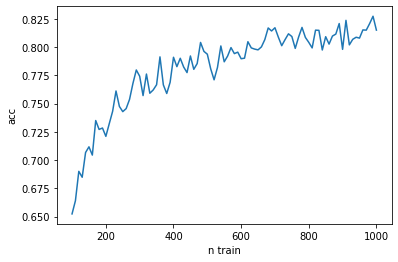

In [ ]:
plt.plot(n,accs)
plt.xlabel('n train')
plt.ylabel('acc')
plt.show()

In [ ]:
ps = [0.01,0.015,0.02,0.03,0.05,0.07,0.1]
accs2 = []

In [ ]:
%%time
for p in ps:
    temp = []
    for i in range(3):
        data_bow1 = data_bow[data_bow.columns[(colmeans[0]>p) & (colmeans[0]<0.5)]]
        X_train, X_rest, y_train, y_rest = train_test_split(data_bow1, y_bat, test_size=0.8)
        X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.6)
        X_train = np.array(X_train.reset_index(drop=True))
        X_test = np.array(X_test.reset_index(drop=True))
        X_valid = np.array(X_valid.reset_index(drop=True))
        model = Sequential()
        model.add(Dense(512, input_shape=(X_train.shape[1],)))
        model.add(Dropout(.2))
        model.add(Dense(256))
        model.add(Dropout(.2))
        model.add(Dense(128))
        model.add(Dropout(.2))
        model.add(Dense(64))
        model.add(Dense(2, activation=tf.keras.activations.softmax))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_valid,y_valid),verbose=0)
        y_hat = model.predict(X_test)
        y_hat_labels = np.array([np.argmax(y_i) for y_i in y_hat])
        y_test_labels = np.array([np.argmax(y_i) for y_i in y_test])
        temp.append(np.mean(y_hat_labels == y_test_labels))
    accs2.append(np.mean(np.array(temp)))

30/30 [==============================] - 0s 3ms/step
CPU times: user 1min 21s, sys: 3.56 s, total: 1min 25s
Wall time: 1min 31s


In [ ]:
# bag-of-words model accuray for different least occuring words cutoff thresholds

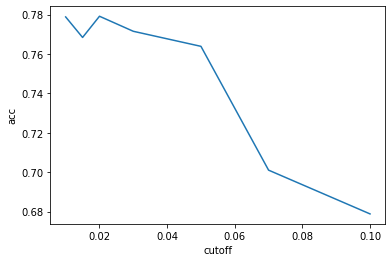

In [ ]:
plt.plot(ps,accs2)
plt.xlabel('cutoff')
plt.ylabel('acc')
plt.show()

In [ ]:
ps = [0.01,0.015,0.02,0.03,0.05,0.07,0.1]
bow_len = []
for p in ps:
    data_bow1 = data_bow[data_bow.columns[(colmeans[0]>p) & (colmeans[0]<0.5)]]
    bow_len.append(len(data_bow1.columns))

In [ ]:
# bag-of-words vector columns for different least occuring words cutoff thresholds

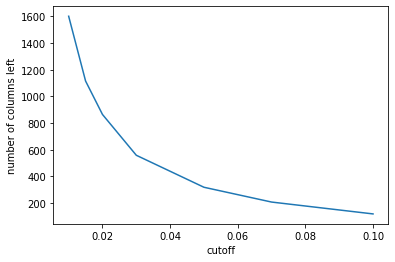

In [ ]:
plt.plot(ps,bow_len)
plt.xlabel('cutoff')
plt.ylabel('number of columns')
plt.show()

# Bag-of-Words contrastive with double input and one MLP - experimental

In [ ]:
y = np.asarray(df.iloc[:,1])
y[y=="positive"] = 1
y[y=="negative"] = 0
y = y.reshape(-1,1).astype('float32')

In [ ]:
y_bat = to_categorical(y)
X_train, X_rest, y_train, y_rest = train_test_split(data_bow1, y_bat, test_size=len(y_bat)-1000)
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5)
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.6)
X_train = np.array(X_train.reset_index(drop=True))
X_test = np.array(X_test.reset_index(drop=True))
X_valid = np.array(X_valid.reset_index(drop=True))

In [ ]:
y_train_c = []
for x1,x2,y1,y2 in zip(X_train1,X_train2,y_train1,y_train2):
    if y1[0] == y2[0]:
        y_train_c.append(1)
    else:
        y_train_c.append(0)

In [ ]:
y_train_c = np.asarray(y_train_c)
y_train_c = y_train_c.reshape(-1,1).astype('float32')
y_train_c = to_categorical(y_train_c)

In [ ]:
# input1 = Input(shape=(X_train1.shape[1],))
# input2 = Input(shape=(X_train2.shape[1],))
# a = Dense(512, activation="relu")(input1)
# a = Dropout(0.2)(a)
# a = Dense(256, activation="relu")(a)
# a = Dropout(0.2)(a)
# a = Dense(128, activation="relu")(a)
# a = Dropout(0.2)(a)
# a = Dense(64, activation="relu")(a)
# a = Model(inputs=input1, outputs=a)
# b = Dense(512, activation="relu")(input2)
# b = Dropout(0.2)(b)
# b = Dense(256, activation="relu")(b)
# b = Dropout(0.2)(b)
# b = Dense(128, activation="relu")(b)
# b = Dropout(0.2)(b)
# b = Dense(64, activation="relu")(b)
# b = Model(inputs=input2, outputs=b)
# combined = Concatenate()([a.output, b.output])
# z = Dense(64, activation="relu")(combined)
# z = Dense(32, activation="relu")(z)
# z = Dense(2, activation="softmax")(z)
# model = Model(inputs=[a.input, b.input], outputs=z)

In [ ]:
input1 = Input(shape=(X_train1.shape[1],))
input2 = Input(shape=(X_train2.shape[1],))
combined = Concatenate()([input1, input2])
b = Dense(1024, activation="relu")(combined)
b = Dropout(0.2)(b)
b = Dense(512, activation="relu")(b)
b = Dropout(0.2)(b)
b = Dense(256, activation="relu")(b)
b = Dropout(0.2)(b)
b = Dense(128, activation="relu")(b)
b = Dropout(0.2)(b)
b = Dense(64, activation="relu")(b)
b = Dropout(0.2)(b)
b = Dense(2, activation="softmax")(b)
model = Model(inputs=[input1, input2], outputs=b)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1601)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1601)]       0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3202)         0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 500)          1601500     ['concatenate_1[0][0]']    

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
model.fit([X_train1,X_train2], y_train_c, epochs=10, batch_size=64)

Epoch 1/10
8/8 [==============================] - 1s 21ms/step - loss: 0.6958 - accuracy: 0.5280
Epoch 2/10
8/8 [==============================] - 0s 22ms/step - loss: 0.6728 - accuracy: 0.6280
Epoch 3/10
8/8 [==============================] - 0s 21ms/step - loss: 0.6600 - accuracy: 0.6960
Epoch 4/10
8/8 [==============================] - 0s 21ms/step - loss: 0.6458 - accuracy: 0.7560
Epoch 5/10
8/8 [==============================] - 0s 20ms/step - loss: 0.6252 - accuracy: 0.7900
Epoch 6/10
8/8 [==============================] - 0s 23ms/step - loss: 0.5983 - accuracy: 0.8600
Epoch 7/10
8/8 [==============================] - 0s 22ms/step - loss: 0.5735 - accuracy: 0.8920
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.5423 - accuracy: 0.9200
Epoch 9/10
8/8 [==============================] - 0s 21ms/step - loss: 0.5102 - accuracy: 0.9340
Epoch 10/10
8/8 [==============================] - 0s 21ms/step - loss: 0.4690 - accuracy: 0.9740
CPU times: user 3.39 s, sys: 

In [ ]:
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5)

In [ ]:
y_test_c = []
for x1,x2,y1,y2 in zip(X_test1,X_test2,y_test1,y_test2):
    if y1[0] == y2[0]:
        y_test_c.append(1)
    else:
        y_test_c.append(0)

In [ ]:
y_test_c = np.asarray(y_test_c)
y_test_c = y_test_c.reshape(-1,1).astype('float32')
y_test_c = to_categorical(y_test_c)

In [ ]:
y_hat_c = model.predict([X_test1, X_test2])
y_hatc_labels = np.array([np.argmax(y_i) for y_i in y_hat_c])
y_testc_labels = np.array([np.argmax(y_i) for y_i in y_test_c])
np.mean(y_hatc_labels == y_testc_labels)

10/10 [==============================] - 0s 8ms/step


0.46

In [ ]:
np.sum(y_hatc_labels)/len(y_hatc_labels)

0.48333333333333334

In [ ]:
np.sum(y_testc_labels)/len(y_testc_labels)

0.51

In [ ]:
y_testc_labels

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0])